In [49]:
from IPython.display import Markdown, display, HTML
import warnings
warnings.filterwarnings('ignore')

# Dialog Skill Analysis for Watson Assistant

## Introduction
Dialog Skill Analysis for Watson Assistant (WA) is intended for use by chatbot designers, developers & data scientists who would like to experiment with and improve on their existing dialog skill design.  

We assume familiarity with the Watson Assistant product as well as concepts involved in dialog skill design like intent, entities, utterances etc.   

### Environment
python 3.6 or greater is required. For dependency requirements, please refer to `requirements.txt`

### Usage
1. Assumes familiarity using a Python Jupyter notebook
2. Assumes a Python 3.6 or greater environment
3. Install dependencies with `pip install -r requirements.txt`  
4. Start jupyter server with `jupyter notebook`
5. Select `skill_analysis.ipynb` to start session

### Link to Source Repository
https://github.com/watson-developer-cloud/assistant-dialog-skill-analysis

In [50]:
!pip install --index-url https://pypi.python.org/simple  -U "pip"
!pip install --index-url https://pypi.python.org/simple  -U "assistant-skill-analysis>=2.0.1"

Looking in indexes: https://pypi.python.org/simple
Looking in indexes: https://pypi.python.org/simple


In [51]:
# Standard python libraries
import sys, os
import json
import importlib
from collections import Counter

# External python libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import ibm_watson

# Internal python libraries
from assistant_dialog_skill_analysis.utils import skills_util, lang_utils
from assistant_dialog_skill_analysis.highlighting import highlighter
from assistant_dialog_skill_analysis.data_analysis import summary_generator
from assistant_dialog_skill_analysis.data_analysis import divergence_analyzer
from assistant_dialog_skill_analysis.data_analysis import similarity_analyzer
from assistant_dialog_skill_analysis.term_analysis import chi2_analyzer
from assistant_dialog_skill_analysis.term_analysis import keyword_analyzer
from assistant_dialog_skill_analysis.term_analysis import entity_analyzer
from assistant_dialog_skill_analysis.confidence_analysis import confidence_analyzer
from assistant_dialog_skill_analysis.inferencing import inferencer
from assistant_dialog_skill_analysis.experimentation import data_manipulator

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haodeqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/haodeqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Table of Contents

1. [Part 1: Training Data Analysis](#part1)<br>
    1.1 [Process Dialog Skill Training Data](#part1.1)<br>
    1.2 [Data Distribution Analsis](#part1.2)<br>
    1.3 [Term Analysis - Correlation Analysis](#part1.3)<br>
    1.4 [Term Analysis - Heat Map](#part1.4)<br>
    1.5 [Ambiguity in Training Data](#part1.5)<br>
2. [Part 2: Model Analysis](#part2)<br>
    2.1 [Model Analysis](#part2.1)<br>
3. [Part 3: Advanced Analysis](#part3)<br>
    3.1 [Analysis using Confidence Thresholds](#part3.1)<br>
    3.2 [Term Importance Highlighting](#part3.2)<br>
    3.3 [Abnormal Confidence Analysis](#part3.3)<br>
    3.4 [Analysis using Correlated Entities per Intent](#part3.4)<br>
4. [Summary](#part4)<br>

<a id='part1'></a>
# Part 1 : Training Data Analysis

<a id='setup'></a>
## Setup: Access Training Data

Please provide access credentials for an existing dialog skill that you would like to analyze.  
Have your API Key & Workspace ID values handy

In [52]:
importlib.reload(skills_util)

# Change Assistant API version if needed
# Find Latest --> https://cloud.ibm.com/docs/services/assistant?topic=assistant-release-notes
API_VERSION = '2020-04-01'

# choose a datacenter to use
datacenters = {
    'dallas': ('https://api.us-south.assistant.watson.cloud.ibm.com', 'https://iam.cloud.ibm.com/identity/token'),
    'washington': ('https://api.us-east.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
    'frankfurt' : ('https://api.eu-de.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
    'sydney'    : ('https://api.au-syd.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
    'tokyo'     : ('https://api.jp-tok.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
    'london'    : ('https://api.eu-gb.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
}

URL, authenticator_url = datacenters['dallas']

# For ICP(IBM Cloud Private), you can disable SSL verification by changing this to True
DISABLE_SSL_VERTIFICATION = False 

# By default we only need the IAM API Key & the Workspace ID

# If you run the notebook regularly you can uncomment the two lines below
# & comment out the line after it
#iam_apikey = '###'
#workspace_id = '###'
iam_apikey, workspace_id = skills_util.input_credentials()
conversation = skills_util.retrieve_conversation(iam_apikey=iam_apikey,
                                                 url=URL,
                                                 api_version=API_VERSION,
                                                 authenticator_url=authenticator_url)

#If you do not have IAM based API Keys
#but have access to a Username, Password & Workspace ID
#You can comment out the two lines above & uncomment the lines below to authenticate
# username = 'apikey'
# password = '###'
# workspace_id = '###'
# conversation = skills_util.retrieve_conversation(username=username,
#                                              password=password,                                                       
#                                              url=URL,
#                                              api_version=API_VERSION)


conversation.set_disable_ssl_verification(DISABLE_SSL_VERTIFICATION)

workspace = skills_util.retrieve_workspace(workspace_id=workspace_id,
                                           conversation=conversation)

Please enter apikey: ········
Please enter workspace-id: ········


Pick the language code correspond to your workspace data:   
*Supported Language codes:* **en, fr, de, es, cs, it, pt**

In [53]:
importlib.reload(lang_utils)
LANGUAGE_CODE="en" # change the language code to work with other languages
lang_util = lang_utils.LanguageUtility(LANGUAGE_CODE)

In [54]:
# Extract user workspace
workspace_pd, workspace_vocabulary = skills_util.extract_workspace_data(workspace, language_util=lang_util)
entity_dict = conversation.list_entities(workspace_id).get_result()
entities_list = [item['entity'] for item in entity_dict['entities']]


display(Markdown("### Sample of Utterances & Intents"))
display(HTML(workspace_pd.sample(n = len(workspace_pd) if len(workspace_pd)<10 else 10)
             .to_html(index=False)))
if entities_list:
    display(Markdown("### Sample of Entities"))
    display(HTML(pd.DataFrame({"Entity":entities_list})
                 .sample(n = len(entities_list) if len(entities_list)<10 else 10)
                 .to_html(index=False)))

### Sample of Utterances & Intents

utterance,intent,tokens
could you please transfer me to your master,General_Connect_to_Agent,"[could, you, pleas, transfer, me, to, your, master]"
bye,Goodbye,[bye]
that is nice of you,Thanks,"[that, is, nice, of, you]"
customer service representative please,General_Connect_to_Agent,"[custom, servic, repres, pleas]"
send me to an agent,General_Connect_to_Agent,"[send, me, to, an, agent]"
make an appointment,Customer_Care_Appointments,"[make, an, appoint]"
are you closing early today,Customer_Care_Store_Hours,"[are, you, close, earli, today]"
pls connect,General_Connect_to_Agent,"[pls, connect]"
nevermind,Cancel,[nevermind]
what is up,General_Greetings,"[what, is, up]"


### Sample of Entities

Entity
sys-time
landmark
zip_code
sys-date
specialist
reply
holiday
phone
sys-number


<a id='part1.1'></a>
## 1.1 Process Dialog Skill Training Data

We generate summary statistics related to the given skill & workspace

In [55]:
importlib.reload(summary_generator)
summary_generator.generate_summary_statistics(workspace_pd, entities_list)

### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,162
2,Unique Intents,9
3,Average User Examples per Intent,18
4,Standard Deviation from Average,13
5,Total Number of Entities,9


<a id='part1.2'></a>
## 1.2 Data Distribution Analysis

### Class Imbalance Analysis

We analyze whether the dataset contains class imbalance by checking whether the largest intent contains less than double the number of user examples contained in the smallest intent. Presence of imbalance does not necessarily indicate an issue, please review the actions section below

In [56]:
importlib.reload(summary_generator)
class_imb_flag = summary_generator.class_imbalance_analysis(workspace_pd)

### <font style='color:rgb(165, 34, 34);'> Class Imbalance Detected         </font>

- Data could be potentially biased towards intents with more user         examples

- E.g. Intent < Customer_Care_Store_Hours > has < 39 > user examples while intent < Goodbye > has         just < 5 > user examples 

### Distribution of User Examples by Intent
We display the distribution of intents vs the number of examples per intent (sorted by the number of examples per intent) below. Ideally we should not have large variations in terms of number of user examples for various intents. 

## <p style="text-align: center;">Sorted Distribution of User Examples                      per Intent</p>

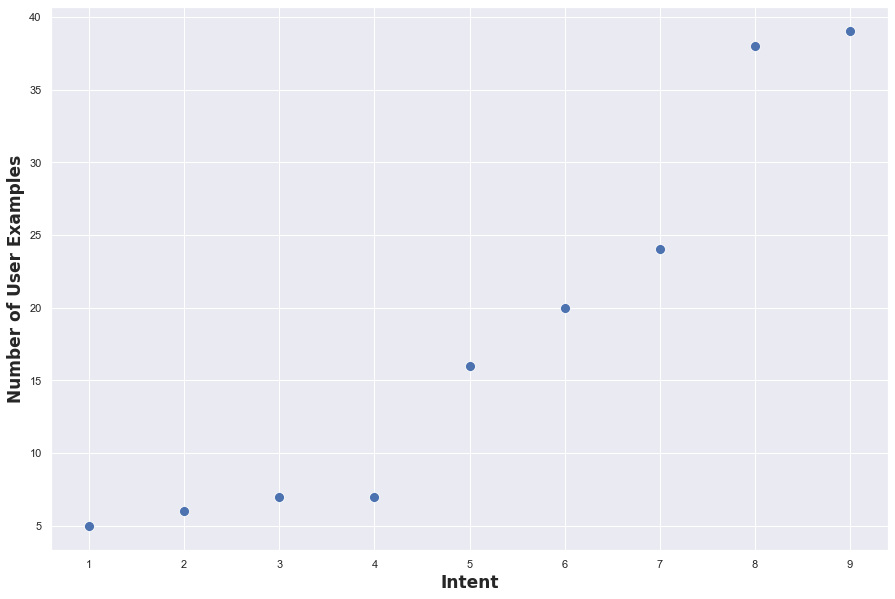

In [57]:
importlib.reload(summary_generator)
summary_generator.scatter_plot_intent_dist(workspace_pd)

In [58]:
importlib.reload(summary_generator)
summary_generator.show_user_examples_per_intent(workspace_pd)

### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,Goodbye,5
2,Cancel,6
3,Help,7
4,Thanks,7
5,Customer_Care_Appointments,16
6,Customer_Care_Store_Location,20
7,General_Greetings,24
8,General_Connect_to_Agent,38
9,Customer_Care_Store_Hours,39


### Actions for Class Imbalance

Class imbalance will not always lead to lower accuracy. All intents (classes) thus need not have the same number of examples.

1. For intents like `updateBankAccount` and `addNewAccountHolder` where the semantics difference between them is subtler, the number of examples per intent needs to be somewhat balanced else the classifier might favor the intent with the higher number of examples.
2. For intents like `greetings` that are semantically distinct from other intents like `updateBankAccount`, it may be okay for it to have fewer examples per intent and still be easy for the intent detector to classify.

If during testing it seems like intent classification accuracy is lower than expected, we advise you to re-examine this distribution analysis.  

With regard to sorted distribution of examples per intent, if the sorted number of user examples varies a lot across different intents, it can be a potential source of bias for intent detection. Large imbalances in general should be avoided. This can potentially lead to lower accuracy. If your graph displays this characteristic, this might be a source of error.

For further guidance on adding more examples to help balance out your distribution, please refer to 
<a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intent-recommendations#intent-recommendations-get-example-recommendations" target="_blank" rel="noopener no referrer">Intent-Example-Recommendation</a>

<a id='part1.3'></a>
## 1.3 Term Analysis - Correlation Analysis

### Retrieve the most correlated unigrams and bigrams for each intent

We perform a chi square significance test using count features to determine the terms that are most correlated with each intent in the dataset. 

A `unigram` is a single word, while a `bigram` is two consecutive words from within the training data. E.g. If you have a sentence like `Thank you for your service`, each of the words in the sentence are considered unigrams while terms like `Thank you`, `your service` are considered bigrams.

If you see terms like `hi`, `hello` correlated with a `greeting` intent that would be reasonable. But if you see terms like `table`, `chair` correlated with the `greeting` intent that would be anomalous. A scan of the most correlated unigrams & bigrams for each intent can help you spot potential anomalies within your training data.

**Note**: We ignore the following common words from consideration `an, a, in, on, be, or, of, a, and, can, is, to, the, i`

In [59]:
importlib.reload(chi2_analyzer)
unigram_intent_dict, bigram_intent_dict = chi2_analyzer.get_chi2_analysis(workspace_pd, lang_util=lang_util)

## Chi-squared Analysis

,Intent,Correlated Unigrams,Correlated Bigrams
1,Customer_Care_Store_Hours,"what, close, hour, are, open","are you, store open, you close, what are, you open"
2,General_Connect_to_Agent,"talk, pleas, person, speak, agent","agent help, connect agent, like speak, connect me, live person"
3,General_Greetings,"hi, look, hello, good, hey","hey how, hey you, hi advisor, hey there, how are"
4,Customer_Care_Store_Location,"find, give, direct, get, where","do get, find store, where are, how do, get your"
5,Customer_Care_Appointments,"next, visit, face, make, appoint","could speak, d like, like make, face face, make appoint"
6,Thanks,"much, nice, thx, veri, thank","nice you, that nice, veri much, you veri, thank you"
7,Help,"need, me, assist, decid, help","me decid, need assist, what do, you help, help me"
8,Cancel,"forget, cancel, tabl, anymor, mind","want tabl, forget it, cancel that, anymor anymor, tabl anymor"
9,Goodbye,"long, arrivederci, see, ya, bye","good bye, see ya, so long"


### Actions for Anomalous Correlations

If you identify unusual / anomalous correlated terms like: numbers, names etc., which should not be correlated with an intent please read the following:
  
- **Case 1** : If you see names appearing amongst correlated unigrams or bigrams, add more variation of names so no specific names will be correlated  
- **Case 2** : If you see specific numbers like 1234 amongst correlated unigrams or bigrams and are not helpful to the use case, remove or mask these numbers from the examples
- **Case 3** : If you see terms which should never be correlated to that specific intent, consider adding or removing terms/examples so that domain specific terms are correlated with the correct intent

<a id='part1.4'></a>
## 1.4 Term Analysis - Heat Map

A heatmap of terms is a method using which we can visualize which terms or words are frequently occurring within each intent. Rows are the terms and columns are the intents. 

By default we show only the top 30 intents with the highest number of user examples in the analysis. This number can be changed if needed.

## <p style="text-align: center;"> Token Frequency per Intent </p>

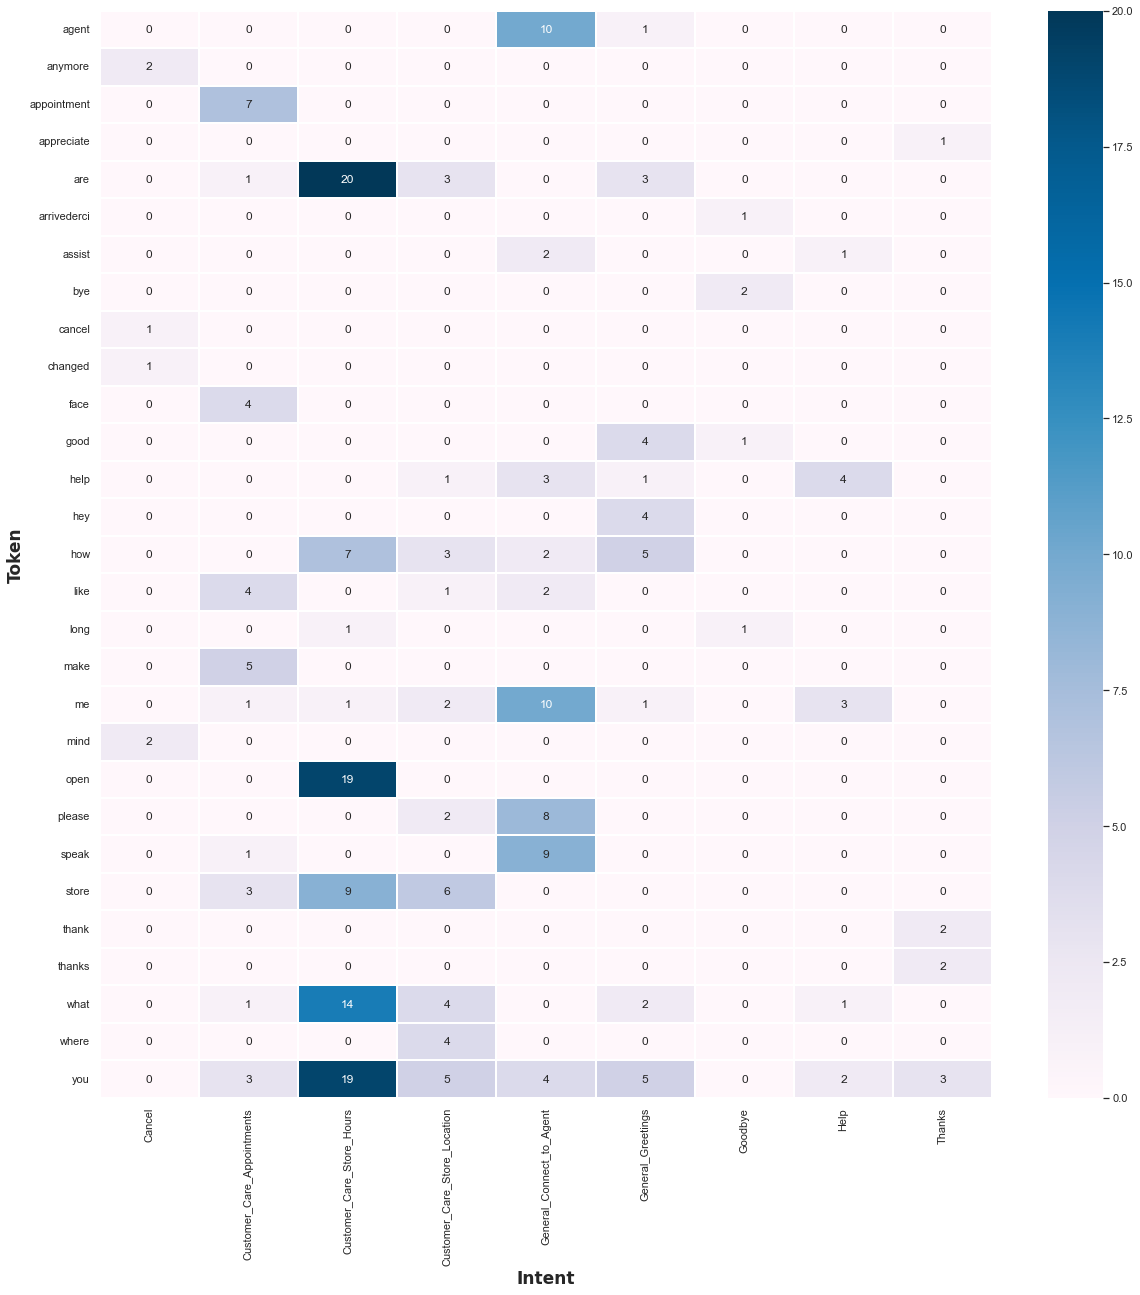

In [60]:
importlib.reload(keyword_analyzer)

INTENTS_TO_DISPLAY = 30  # Total number of intents for display
MAX_TERMS_DISPLAY = 30  # Total number of terms to display

intent_list = []
keyword_analyzer.seaborn_heatmap(workspace_pd, lang_util, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Term Analysis for Custom Intent List

If you wish to see term analysis for specific intents, feel free to add those intents to the intent list. This shall generate a custom term heatmap. By default we show the top 30 tokens, but this can be changed if needed

In [61]:
importlib.reload(keyword_analyzer)
# intent_list = ['intent1','intent2','intent3'] 
intent_list = [] 


MAX_TERMS_DISPLAY = 20  # Total number of terms to display

if intent_list: 
    keyword_analyzer.seaborn_heatmap(workspace_pd, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Actions for Anomalous Terms in Heat Map

If you notice any terms or words which should not be frequently present within an intent, consider modifying examples in that intent

<a id='part1.5'></a>
## 1.5 Ambiguity in Training Data
### Uncover possibly ambiguous terms based on feature correlation
Based on the chi-square analysis above, we generate intent pairs whose correlated unigrams and bigrams overlap.
This allows us to get a glimpse of which unigrams or bigrams might cause potential confusion in intent detection.

### A. Top Intent Pairs whose correlated unigrams overlap

In [62]:
importlib.reload(chi2_analyzer)
ambiguous_unigram_df = chi2_analyzer.get_confusing_key_terms(unigram_intent_dict)

There is no ambiguity based on top 5 key terms in chi2 analysis

### B. Top Intent Pairs whose correlated bigrams overlap

In [63]:
importlib.reload(chi2_analyzer)
ambiguous_bigram_df = chi2_analyzer.get_confusing_key_terms(bigram_intent_dict)

There is no ambiguity based on top 5 key terms in chi2 analysis

### C. Overlap Checker for Specific Intents

In [64]:
# Add specific intent or intent pairs for which you would like to see overlap
importlib.reload(chi2_analyzer)
intent1 = 'Goodbye'
intent2 = ''
chi2_analyzer.chi2_overlap_check(ambiguous_unigram_df,ambiguous_bigram_df,intent1,intent2)

### Uncover ambiguous utterances across intents
The following analysis shows user examples that are similar but fall under different Intents.  

In [65]:
importlib.reload(similarity_analyzer)
similar_utterance_diff_intent_pd = similarity_analyzer.ambiguous_examples_analysis(workspace_pd, lang_util)

### There are no similar utterances within different Intent

## Actions for Ambiguity in Training Data

**Ambiguous Intent Pairs**  
If you see terms which are correlated with more than 1 intent, please review if this seems anomalous based on the use case for that intent. If it seems reasonable, it may not be an issue.  

**Ambiguous Utterances across intents** 
1. **Duplicates Utterances**: For duplicate or almost identical utterances, remove those that seem unnecessary
2. **Similar Utterances**: For similar utterances please review the use case for those intents and make sure that they are not accidental additions caused by human error in creating the training data  

Reference for more information on entity: <a href="https://cloud.ibm.com/docs/services/assistant/services/assistant?topic=assistant-entities" target="_blank" rel="noopener no referrer">Entity Documentation</a>

For more in-depth analysis related to possible conflicts in your training data across intents, try the conflict detection feature in Watson Assistant: <br> <a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts" target="_blank" rel="noopener no referrer">Conflict Resolution Documentation</a>

<a id='part2'></a>
# Part 2: Model Analysis

Analyze your existing Watson Assistant Dialog Skill with the help of a test set.

## Setup: Upload Test Data
Please upload a test set in csv format. Each line in the file should have only `User_Input<comma>Intent`  

An example would be
```
hello how are you<comma>Greeting  
I would like to talk to a human<comma>AgentHandoff  
```


In [66]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# The following code accesses a csv file in your IBM Cloud Object Storage.
ENDPOINT_URL = 'https://s3.us-east.cloud-object-storage.appdomain.cloud' # change this based on the region of your cos bucket 


# please fill in the details here:
COS_API_KEY_ID = 'YOUR_COS_API_KEY'
RESOURCE_INSTANCE_ID = 'YOUR_COS_RESOURCE_INSTANCE_ID'
IBM_COS_BUCKET = 'YOUR_COS_BUCKET_NAME'
IBM_COS_FILE_KEY = 'YOUR_COS_FILE_NAME'


cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id = RESOURCE_INSTANCE_ID,
    config=Config(signature_version='oauth'),
    endpoint_url=ENDPOINT_URL)

body = cos_client.get_object(Bucket=IBM_COS_BUCKET,Key=IBM_COS_FILE_KEY)['Body']
# add missing __iter__ method
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    
separator = "," # separator used in csv.
    
test_df = skills_util.process_test_set(body, lang_util, delim=separator, cos=True)
display(Markdown("### Random Test Sample"))
display(HTML(test_df.sample(n=min(10, len(test_df))).to_html(index=False)))   

### Random Test Sample

utterance,intent,tokens
can i speak with somebody,General_Connect_to_Agent,"[can, i, speak, with, somebodi]"
hi advisor,General_Greetings,"[hi, advisor]"
thank you,Thanks,"[thank, you]"
looking good eve,General_Greetings,"[look, good, eve]"
are you open on sunday,Customer_Care_Store_Hours,"[are, you, open, on, sunday]"
is the store going to be open tomorrow,Customer_Care_Store_Hours,"[is, the, store, go, to, be, open, tomorrow]"
how early do you open on saturdays,Customer_Care_Store_Hours,"[how, earli, do, you, open, on, saturday]"
can i talk to someone,General_Connect_to_Agent,"[can, i, talk, to, someon]"
can you help me change my account password,SYSTEM_OUT_OF_DOMAIN,"[can, you, help, me, chang, my, account, password]"
find store,Customer_Care_Store_Location,"[find, store]"


## Evaluate Test Data
These steps can take time if you have a large test set  

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan 

In [81]:
THREAD_NUM = min(4, os.cpu_count() if os.cpu_count() else 1)

full_results = inferencer.inference(conversation=conversation,
                                    test_data=test_df,
                                    max_thread=THREAD_NUM, 
                                    workspace_id=workspace_id,
                                   )

Starting Thread-1Starting Thread-2
Starting Thread-3

Starting Thread-4
Exiting Thread-2
Exiting Thread-3
Exiting Thread-1
Exiting Thread-4
--- Total time: 8.077019214630127 seconds ---


<a id='part2.1'></a>
## 2.1 Model Analysis

### Test Data Overview

In [82]:
importlib.reload(summary_generator)
summary_generator.generate_summary_statistics(test_df)
summary_generator.show_user_examples_per_intent(test_df)

### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,53
2,Unique Intents,10
3,Average User Examples per Intent,5
4,Standard Deviation from Average,3
5,Total Number of Entities,0


### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,Help,2
2,Thanks,2
3,Cancel,3
4,Goodbye,3
5,Customer_Care_Store_Location,5
6,Customer_Care_Appointments,5
7,SYSTEM_OUT_OF_DOMAIN,7
8,General_Greetings,7
9,Customer_Care_Store_Hours,9
10,General_Connect_to_Agent,10


### Compare Test Data & Training Data

Ideally the Test and Training Data distributions should be similar. The following metrics can help identify gaps between Test Set and Training Set:

**1.**  The distribution of User Examples per Intent for the Test Data should be comparable to the Training Data   
**2.**  Average length of User Examples for Test and Training Data should be comparable  
**3.**  The vocabulary and phrasing of utterances in the Test Data should be comparable to the Training Data

If your test data comprises of examples labelled from your logs, and the training data comprises of examples created by human subject matter experts, there may be discrepancies between what the virtual assistant designers thought the end users would type and the way they actually type in production. Thus, if you find discrepancies in this section, you might want to consider changing your design to more closely resemble the way end users use your system.

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan

In [83]:
importlib.reload(divergence_analyzer)
divergence_analyzer.analyze_train_test_diff(workspace_pd, test_df, full_results)

## Test Data Evaluation

,Intent,% of Train,% of Test,Absolute Difference %,Train Examples,Test Examples,Test Precision %,Test Recall %,Test F1 %
0,Customer_Care_Store_Hours,24.070000,16.980000,7.090000,39,9,90.000000,100.000000,94.740000
1,General_Connect_to_Agent,23.460000,18.870000,4.590000,38,10,81.820000,90.000000,85.710000
3,Customer_Care_Store_Location,12.350000,9.430000,2.910000,20,5,55.560000,100.000000,71.430000
8,Goodbye,3.090000,5.660000,2.570000,5,3,100.000000,33.330000,50.000000
7,Cancel,3.700000,5.660000,1.960000,6,3,100.000000,100.000000,100.000000
2,General_Greetings,14.810000,13.210000,1.610000,24,7,77.780000,100.000000,87.500000
5,Thanks,4.320000,3.770000,0.550000,7,2,100.000000,100.000000,100.000000
6,Help,4.320000,3.770000,0.550000,7,2,66.670000,100.000000,80.000000
4,Customer_Care_Appointments,9.880000,9.430000,0.440000,16,5,100.000000,100.000000,100.000000


Distribution Mismatch Color Code

<font color = 'red'>      Red - Severe </font>

<font color = 'blue'>     Blue - Caution </font>

<font color = 'green'>    Green - Good </font>

### Data Distribution Divergence Test vs Train         <font color='blue'>10.0%</font>

**Note** Metric used is Jensen Shannon Distance

### Test Data Example Length

Average length of user examples is comparable

### Vocabulary Size Test vs Train

,Train Vocabulary Size,Test Vocabulary Size,% Test Set Vocabulary not found in Train
1,199,125,21.6


### Determine Overall Accuracy on Test Set

In [84]:
importlib.reload(inferencer)
results = full_results[['correct_intent', 'top_confidence','top_intent','utterance']]
accuracy = inferencer.calculate_accuracy(results)
display(Markdown("### Accuracy on Test Data: {} %".format(accuracy)))

### Accuracy on Test Data: 81.13 %

### Error Analysis

This section gives the user an overview of the errors made by the intent classifier on the test set  

**Note** `System Out of Domain` labels are assigned to user examples which get classified with confidence scores less than 0.2 as Watson Assistant would consider them to be irrelevant

In [85]:
importlib.reload(inferencer)
wrongs_df = inferencer.calculate_mistakes(results)
display(Markdown("### Intent Detection Mistakes"))
display(Markdown("Number of Test Errors: {}".format(len(wrongs_df))))

with pd.option_context('max_colwidth', 250):
    if not wrongs_df.empty:
        display(wrongs_df)

### Intent Detection Mistakes

Number of Test Errors: 10

,correct_intent,top_confidence,top_intent,utterance
Test Example Index,,,,
2,Goodbye,0.678399,General_Greetings,ciao
33,General_Connect_to_Agent,0.785419,Customer_Care_Store_Location,where is the closest agent
44,SYSTEM_OUT_OF_DOMAIN,0.334192,General_Connect_to_Agent,can you tell me a good joke
46,SYSTEM_OUT_OF_DOMAIN,0.484641,Customer_Care_Store_Location,what is your iq
47,SYSTEM_OUT_OF_DOMAIN,0.161824,Customer_Care_Store_Hours,luke i am your father
48,SYSTEM_OUT_OF_DOMAIN,0.226131,Customer_Care_Store_Location,where did betty buy her butter
49,Goodbye,0.460292,General_Greetings,see you tomorrow
50,SYSTEM_OUT_OF_DOMAIN,0.037622,General_Connect_to_Agent,how many engineers does it take to change a lightbulb
51,SYSTEM_OUT_OF_DOMAIN,0.762546,Customer_Care_Store_Location,what is a way to change my account address


<a id='part3'></a>
## Part 3: Advanced Analysis

<a id='part3.1'></a>
## 3.1 Analysis using Confidence Thresholds

In this phase of the analysis, we illustrate how a confidence threshold which is used to determine what is considered irrelevant or out of domain can be used for analysis 

### Threshold Metrics

We calculate metrics for responses where the top intent has a confidence above the         threshold specified on the x-axis.  

We consider examples which are within the scope of the chatbot's problem formulation as          on topic or in domain and those examples which are outside the scope of the problem to be          out of domain or irrelevant

#### 1) Thresholded On Topic Accuracy (TOA)

x-axis: Confidence threshold used || y-axis: Intent Detection Accuracy for On Topic utterances

#### 2)  Bot Coverage %

x-axis: Confidence threshold used || y-axis: Fraction of All utterances above the threshold

#### 3) False Acceptance Rate for Out of Domain Examples (FAR)

x-axis: Confidence threshold used || y-axis: Fraction of Out of Domain utterances falsely considered on topic

#### Note: Default acceptance threshold for Watson Assistant is set at 0.2.        Utterances with top intent confidence < 0.2 will be considered irrelevant

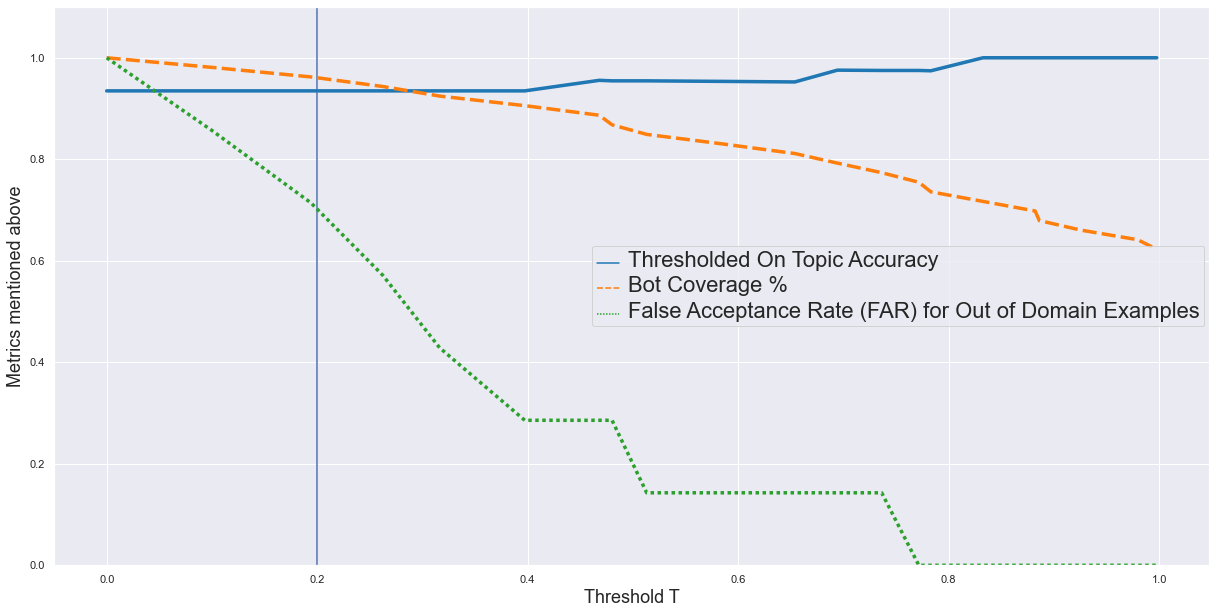

In [86]:
importlib.reload(confidence_analyzer)
analysis_df= confidence_analyzer.analysis(results,None)

## Analysis Interpretation @ Confidence Level T 

If a certain confidence threshold T is selected, then 
1. The on-topic accuracy for test examples which cross the threshold is ***TOA***
2. Percentage of total test examples which returned confidences higher than the threshold measured as ***Bot Coverage %***
3. If out of domain examples exist, we falsely accept out of domain examples as on topic examples at a rate measured by ***FAR***

In [87]:
analysis_df.index = np.arange(1, len(analysis_df)+1)
display(analysis_df)

,Threshold (T),Ontopic Accuracy (TOA),Bot Coverage %,Bot Coverage Counts,False Acceptance Rate (FAR)
1,0.0,93.478261,100.000000,53 / 53,100.000000
2,0.1,93.478261,98.113208,52 / 53,85.714286
3,0.2,93.478261,96.226415,51 / 53,71.428571
4,0.3,93.478261,94.339623,50 / 53,57.142857
5,0.4,93.478261,90.566038,48 / 53,28.571429
6,0.5,95.454545,86.792453,46 / 53,28.571429
7,0.6,95.348837,83.018868,44 / 53,14.285714
8,0.7,97.560976,79.245283,42 / 53,14.285714
9,0.8,97.435897,73.584906,39 / 53,0.000000
10,0.9,100.000000,67.924528,36 / 53,0.000000


## Threshold Selection

By selecting a higher threshold, we can potentially bias our systems towards being more accurate in terms of determining whether an utterance is on topic or out of domain. The default confidence threshold for Watson Assistance is 0.2  

**Effect on Accuracy**: When we select a higher threshold T, this can result in higher accuracy (TOA) because only examples with confidences greater than the threshold T are included.

**Effect on Bot Coverage %**: However, when we select a higher threshold T, this can also result in less examples being responded to by the virtual assistant.

**Deflection to Human Agent**: In the scenarios where the virtual assistant is setup to hand off to a human agent when its less confident, having a higher threshold T can:  

1. Improve end user experience when interacting with a virtual assistant, as it is continuing interaction only when its highly confident
2. But this can result in higher costs to the customer as this can result in more deflections to the human agents 
3. There is thus a trade-off and a threshold need to be decided on a per customer basis

## Threshold Selection on Individual Intents
This section allows the examination of thresholds on specific intents.

- Use INTENT_LIST = [] to get analysis which averages across all intents
- Use INTENT_LIST = ['intent1', 'intent2'] to examine specific intents and threshold analysis on these intents
- Use INTENT_LIST = ['ALL_INTENTS'] to examine all intents and threshold analysis for each
- Use INTENT_LIST = [MOST_FREQUENT_INTENT] to get analysis on the intent with the most test examples (DEFAULT)

**False Acceptance Rate (FAR) for specific intents**  
When we calculate FAR across all intents (as in previous section) we calculate fraction of out of domain examples falsely considered on topic. When we calculate FAR for specific intents, we calculate the fraction of examples which were falsely predicted to be that specific intent.

In [88]:
importlib.reload(confidence_analyzer)

# Calculate intent with most test examples
for label in list(test_df['intent'].value_counts().index):
    if label != skills_util.OFFTOPIC_LABEL:
        MOST_FREQUENT_INTENT = label 
        break
        
# Specify intents of interest for analysis      
INTENT_LIST = [MOST_FREQUENT_INTENT]  

analysis_df_list = confidence_analyzer.analysis(results, INTENT_LIST)

### Threshold Analysis for Intent: General_Connect_to_Agent

Out of Domain examples fewer than **5** thus             no False Acceptance Rate (FAR) calculated

,Threshold (T),Ontopic Accuracy (TOA),Bot Coverage %,Bot Coverage Counts
1,0.0,90.0,100.000000,12 / 12
2,0.1,90.0,100.000000,12 / 12
3,0.2,90.0,91.666667,11 / 12
4,0.3,90.0,91.666667,11 / 12
5,0.4,90.0,91.666667,11 / 12
6,0.5,90.0,91.666667,11 / 12
7,0.6,90.0,83.333333,10 / 12
8,0.7,90.0,83.333333,10 / 12
9,0.8,90.0,83.333333,10 / 12
10,0.9,100.0,75.000000,9 / 12


<a id='part3.2'></a>
## 3.2 Term Importance Highlighting

This intent can be ground-truth or an incorrect predicted intent. It provides term level insights on which terms the classifier thought were important in relation to that specific intent.

Even if the system predicts an intent correctly, the terms which the intent classifier though were important may not be as expected by human insight. Human insight might suggest that the intent classifier is focusing on the wrong terms.  

The score of each term in the following highlighted images can be viewed as importance factor of that term for that specific intent. The larger the score, the more important the term.

We can get the highlighted images for either wrongly-predicted utterances or utterances where the classifier returned a low confidence.   

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan

### Identified 1 problematic utterances 

Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-2
Exiting Thread-4
Exiting Thread-1
Exiting Thread-3
Exiting Thread-5
--- Total time: 0.7478041648864746 seconds ---


1 examples are shown below:

,Characteristic,Value
1,Test Set Index,0
2,Utterance,where is the closest agent
3,Actual Intent,General_Connect_to_Agent
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.785419


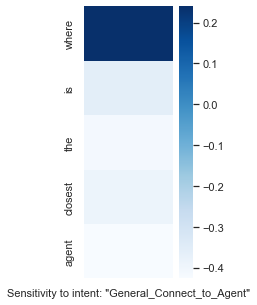

In [89]:
importlib.reload(highlighter)

# Pick an example from section 1 which was misclassified
# Add the example and correct intent for the example
utterance = "where is the closest agent"  # input example
intent = "General_Connect_to_Agent"  # input an intent in your workspace which you are interested in.


inference_results = inferencer.inference(conversation=conversation, 
                                    workspace_id=workspace_id, 
                                    test_data=pd.DataFrame({'utterance':[utterance], 
                                                            'intent':[intent]}), 
                                    max_retries = 10, 
                                    max_thread = 1, 
                                    verbose = False)

highlighter.get_highlights_in_batch_multi_thread(conversation, 
                                                 workspace_id,
                                                 inference_results, 
                                                 None,
                                                 1,
                                                 1,
                                                 lang_util)

In the section below we analyze your test results and produce highlighting for the top 25 problematic utterances which were either mistakes or had confidences below the threshold that was set.    

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan

### Identified 8 problematic utterances 

Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-4
Exiting Thread-2
Exiting Thread-3
Exiting Thread-1
Exiting Thread-5
--- Total time: 4.486269950866699 seconds ---


25 examples are shown below:

,Characteristic,Value
1,Test Set Index,33
2,Utterance,where is the closest agent
3,Actual Intent,General_Connect_to_Agent
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.785419


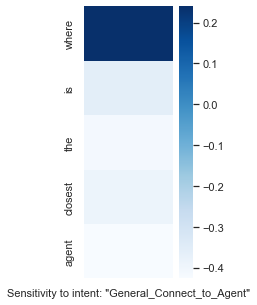

,Characteristic,Value
1,Test Set Index,2
2,Utterance,ciao
3,Actual Intent,Goodbye
4,Predicted Intent,General_Greetings
5,Confidence,0.678399


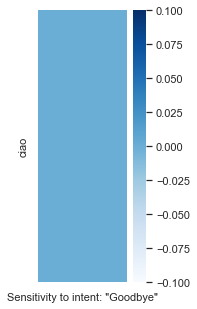

,Characteristic,Value
1,Test Set Index,51
2,Utterance,what is a way to change my account address
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.762546


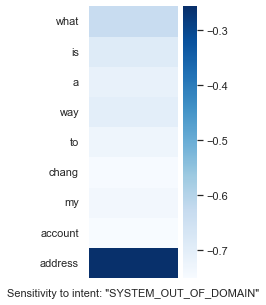

,Characteristic,Value
1,Test Set Index,49
2,Utterance,see you tomorrow
3,Actual Intent,Goodbye
4,Predicted Intent,General_Greetings
5,Confidence,0.460292


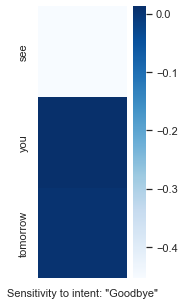

,Characteristic,Value
1,Test Set Index,46
2,Utterance,what is your iq
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.484641


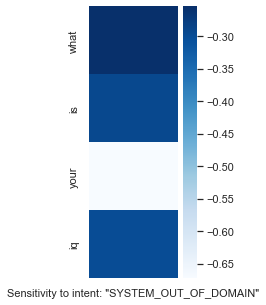

,Characteristic,Value
1,Test Set Index,44
2,Utterance,can you tell me a good joke
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,General_Connect_to_Agent
5,Confidence,0.334192


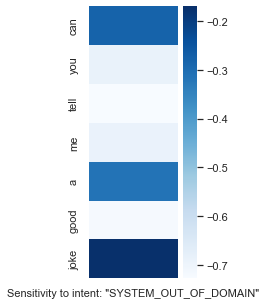

,Characteristic,Value
1,Test Set Index,52
2,Utterance,can you help me change my account password
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Help
5,Confidence,0.298546


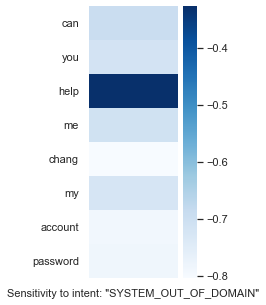

,Characteristic,Value
1,Test Set Index,48
2,Utterance,where did betty buy her butter
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.226131


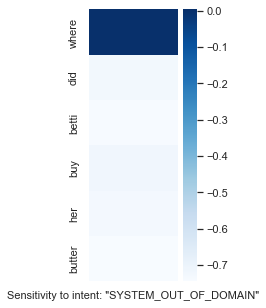

In [90]:
importlib.reload(highlighter)

# The output folder for generated images
# Note modify this if you want the generated images to be stored in a different directory

highlighting_output_folder = './highlighting_images/'
if not os.path.exists(highlighting_output_folder):
    os.mkdir(highlighting_output_folder)

# The threshold the prediction needs to achieve below which  
# it will be considered as `out of domain` or `offtopic` utterances. 
threshold = 0.2

# Maximum number of test set examples whose highlighting analysis will be conducted
K=25
highlighter.get_highlights_in_batch_multi_thread(conversation, 
                                                 workspace_id,full_results, 
                                                 highlighting_output_folder,
                                                 threshold,
                                                 K,
                                                 lang_util)

<a id='part3.3'></a>
## 3.3 Abnormal Confidence Analysis
Every test utterance is classified as a specific intent with a specific confidence by the WA intent classifier. It is expected that model would be confident when correctly predicting examples and not highly confident when incorrectly predicting examples. 

But often this is not true. This may suggest there are anomalies in the design. Examples that are predicted correctly with low confidence and the examples that are predicted incorrectly with high confidence are thus cases which need to be reviewed.

In [91]:
importlib.reload(confidence_analyzer)
correct_thresh, wrong_thresh = 0.3, 0.7
correct_with_low_conf_list, incorrect_with_high_conf_list = confidence_analyzer.abnormal_conf(
    full_results, correct_thresh, wrong_thresh)

In [92]:
if len(correct_with_low_conf_list) > 0:
    display(Markdown("#### Examples correctedly predicted with low confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(correct_with_low_conf_list.to_html(index=False)))

In [93]:
if len(incorrect_with_high_conf_list) > 0:
    display(Markdown("#### Examples incorrectedly predicted with high confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(incorrect_with_high_conf_list.to_html(index=False)))

#### Examples incorrectedly predicted with high confidence

correct_intent,utterance,top1_prediction,top2_prediction,top3_prediction
General_Connect_to_Agent,where is the closest agent,Customer_Care_Store_Location (0.785),General_Connect_to_Agent (0.414),Customer_Care_Store_Hours (0.319)


## Actions for abnormal confidence examples

If there are examples which are getting classified incorrectly with high confidence for specific intents, it may indicate an issue in the design of those specific intents as the user examples provided for that intent may be overlapping with the design of other intents.

If intent A seems to always get misclassified as intent B with high confidence or gets correctly predicted with low confidence, please consider using intent conflict detection https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts

Also consider whether those two intents need to be two separate intents or whether they need to be merged. If they can't be merged, then consider adding more user examples which distinguish intent A specifically from intent B.

<a id='part3.4'></a>
## 3.4 Analysis using Correlated Entities per Intent

We perform a chi square significance test for entities as we did for unigrams and bigrams in the previous section. For each utterance in the training data, this analysis will call the mesage api for entity detection on each utterance and find the most correlated entities for each intent

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan.

In [80]:
importlib.reload(entity_analyzer)
importlib.reload(inferencer)
if entities_list:
    THREAD_NUM = 5# we allow a maximum of 5 threads for faster inference
    train_full_results = inferencer.inference(conversation,
                                              workspace_id,
                                              workspace_pd,
                                              max_retries=10, 
                                              max_thread=THREAD_NUM,
                                              verbose=False)
    entity_label_correlation_df = entity_analyzer.entity_label_correlation_analysis(
        train_full_results, entities_list)
    with pd.option_context('display.max_colwidth', 200):
        entity_label_correlation_df.index = np.arange(1, len(entity_label_correlation_df) + 1)
        display(entity_label_correlation_df)
else:
    display(Markdown("### Target workspace has no entities."))

Starting Thread-1Starting Thread-2

Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-3
Exiting Thread-5
Exiting Thread-4
Exiting Thread-2
Exiting Thread-1
--- Total time: 15.170798063278198 seconds ---


,Intent,Correlated Entities
1,Customer_Care_Store_Hours,"holiday, sys-time, sys-date, reply"
2,Customer_Care_Store_Location,landmark
3,General_Connect_to_Agent,"sys-date, reply"


<a id='part4'></a>
## Part 4: Summary:
Congratulation! You have successfully completed the Dialog Skill Analysis. This notebook is designed for improving our dialog skill analysis in an iterative fashion. You can tackle one aspect of your Dialog Skill at a time and start over for another aspect later for continuous improvement.

##  Glossary

**True Positives (TP):** True Positive measures the number of correctly predicted positive values meaning that predicted class is the same as the actual class which is the target intent.

**True Negatives (TN):** True Negative measures the number of correctly predicted negative values meaning that the predicted class is the same as the actual class which is not the target intent.

**False Positives (FP):** False Positive measures the number of incorrectly predicted positive values meaning that the predicted class is the target intent but the actual class is not the target intent.  

**False Negatives (FN):** False Negatives measures the number of incorrectly predicted negative values meaning that the predicted class is not the target intent but the actual class is the target intent. 

**Accuracy:** Accuracy measures the ratio of corrected predicted user examples out of all user examples.   
Accuracy = (TP + TN) / (TP + TN + FP + FN)  

**Precision:** Precision measures the ratio of correctly predicted positive observations out of total predicted positive observations.   
Precision = TP / (TP + FP)  

**Recall:** Recall measures the ratio of correctly predicted positive observations out of all observations of the target intent.  
Recall = TP / (TP + FN)

**F1 Score:** F1 Score is the harmonic average of Precision and Recall.  
F1 = 2 \* (Precision \* Recall)/ (Precision + Recall)

For more information related to Watson Assistant: 
<a href="https://cloud.ibm.com/docs/services/assistant" target="_blank" rel="noopener no referrer">Watson Assistant Documentation</a>

###  Authors

**Haode Qi** is a data scientist at IBM Watson. He conducts research with NLP technologies and delivers Machine Learning Algorithm into IBM Watson's market leading conversational AI service. He is involved in several IBM open-source projects like the Auto-AI framework Lale and works with a dozen of clients to improve their AI chatbot.

**Navneet Rao** is an engineering lead at IBM Watson. He believes in building unique AI-powered experiences which augment human capabilities. He currently works on AI innovation & research for IBM's award-winning conversational computing platform, the IBM Watson Assistant. 

**Ming Tan**, PhD, is a data scientist at IBM Watson. He is mainly working on prototyping and productization of various algorithmic features related to Watson Assistant service. He demonstrates a broad research interest on deep learning approaches for conversational service and related NLP tasks, such as low-resource intent classification, out-of-domain detection, multi-user chat channels, passage-level semantic matching and entity detection. Multiple research works have been published on top-tier NLP conferences.

**Yang Yu**, PhD, is a data scientist at IBM Watson. His research focusses mainly include language understanding, question answering, deep learning and representations learning methods for different NLP tasks. At IBM, he achieved awards on several internal machine learning competitions with global researchers. A few novel machine learning solutions he designed and developed solved some critical question answering and human-computer dialog problem in general for several popular Watson Services on the market.

<hr>
Copyright &copy; IBM Corp. 2020. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>